# **Visualización Interactiva del Desempeño SIMCE en la Región Metropolitana (2014–2024)**

Este proyecto presenta una visualización interactiva que permite explorar la evolución del desempeño SIMCE de **Lenguaje** y **Matemática** en las comunas de la Región Metropolitana de Chile entre los años **2014 y 2024**.

La herramienta combina un **mapa temático** con un **gráfico temporal**, permitiendo al usuario seleccionar visualmente una comuna y observar cómo han variado sus puntajes a lo largo del tiempo, incluyendo la variabilidad mediante bandas de desviación estándar.

---

## **Preguntas que responde esta visualización**

1. **¿Cómo se distribuyen los puntajes SIMCE entre las comunas de la RM en un año específico?**  
   El mapa muestra el rendimiento relativo entre comunas mediante colores continuos.

2. **¿Cómo ha cambiado el desempeño de una comuna a lo largo del tiempo?**  
   El gráfico temporal revela tendencias, alzas, caídas y el efecto de la pandemia.

3. **¿Qué tan estables son los puntajes de una comuna en el tiempo?**  
   Las bandas de desviación estándar muestran la variabilidad intra-comunal por año.

4. **¿Qué diferencias existen entre Lenguaje y Matemática?**  
   Los botones permiten alternar entre ambas pruebas para comparar comportamientos.

---

## **Metodología (Resumen)**

1. **Fuente de datos:**  
   Base SIMCE oficial por establecimiento de 4° básico (2014–2024), incluyendo puntajes promedio (`prom_lect4b_rbd`, `prom_mate4b_rbd`).

2. **Corrección de códigos comunales:**  
   Algunos años incluían **códigos CUT incorrectos** (especialmente 2015 y 2017).  
   Se construyó un diccionario maestro de códigos válidos y se repararon automáticamente los registros inconsistentes usando el nombre de comuna.

3. **Agregación comunal:**  
   Para cada **año** y **comuna** se calcularon:  
   - Puntaje promedio en Lenguaje  
   - Puntaje promedio en Matemática  
   - Desviación estándar comunal por año (variabilidad intra-comunal)

4. **Construcción del mapa:**  
   Se integró un shapefile/GeoJSON de comunas de la RM con los datos agregados usando el campo `cod_comuna`.

5. **Interactividad (Altair 5):**  
   - Selección de comuna mediante clic en el mapa  
   - Filtro dinámico del gráfico temporal según la selección  
   - Colores dependientes del puntaje  
   - Banda gris para resaltar el período de pandemia (2019–2021)  
   - Banda de desviación estándar alrededor del puntaje anual

---

## **Objetivo del proyecto**

Entregar una herramienta visual que permita:  
- Comparar desempeño entre comunas  
- Detectar tendencias y brechas  
- Evaluar el impacto de eventos críticos (como la pandemia)  
- Simplificar el análisis territorial del SIMCE

---



In [1]:
import sys
import subprocess
import importlib.util

# INSTALACIÓN DE PAQUETES

# Lista de librerías requeridas
required_packages = [
    'pandas',
    'matplotlib',
    'seaborn',
    'numpy',
    'geopandas',
    'ipywidgets',
    'requests',
    'altair',
    'gdown',
    'folium',
    'glob'
]
# Detectar paquetes faltantes
missing = [pkg for pkg in required_packages if importlib.util.find_spec(pkg) is None]

# Instalación automática solo si es necesario
if missing:
    print(f"Instalando dependencias faltantes: {', '.join(missing)}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install"] + missing)
    print("Instalación completada.")
else:
    print("Todas las librerías ya están instaladas.")


# --- IMPORTACIONES ---
import pandas as pd                                 # Manipulación y análisis de datos
import matplotlib.pyplot as plt                     # Gráficos y visualización
import seaborn as sns                               # Visualización estadística de datos
import numpy as np                                  # Operaciones numéricas
import geopandas as gpd                             # Manipulación de datos geoespaciales
import altair as alt                                # Visualización estadística declarativa
import warnings                                     # Control de advertencias

import ipywidgets as widgets                        # Widgets interactivos para Jupyter
from IPython.display import display, clear_output   # Utilidades de visualización para Jupyter

import os                                           # Interfaces del sistema operativo
import requests                                     # Librería HTTP para realizar solicitudes
import gdown                                        # Descargar archivos de Google Drive
import glob                                         # Búsqueda de archivos por patrones


Todas las librerías ya están instaladas.


Se descarga la base de datos y se guarda en una carpeta llamada Datos

In [ ]:
# Enlaces de descarga
enlace_descarga = "https://drive.usercontent.google.com/download?id=14cr_NcbnRlxGBAE2KwluXO5RWcV7h27a&export=download&authuser=0&confirm=t&uuid=ab338839-bb46-415c-9e0b-baa349f66125&at=ALWLOp58TXtgKEDFavl5Kn2Hru6H:1762816912784"
enlace_carpeta_drive = "https://drive.google.com/drive/folders/1UHXZ7ceSrMxmdTPz_1mmYudib-iUvrOJ"

# Configuración de carpetas y nombres
carpeta_datos = "Datos"
archivo_excel = "RBDSimce4toBasico2014-2024.xlsx"
carpeta_comunas = "Comunas"

# Crear carpeta principal si no existe
os.makedirs(carpeta_datos, exist_ok=True)
ruta_archivo = os.path.join(carpeta_datos, archivo_excel)

# Descargar archivo principal
respuesta = requests.get(enlace_descarga)
with open(ruta_archivo, 'wb') as archivo_destino:
    archivo_destino.write(respuesta.content)
print(f"Archivo descargado exitosamente en: {ruta_archivo}")

# Descargar carpeta de comunas
ruta_comunas = os.path.join(carpeta_datos, carpeta_comunas)
print(f"Descargando carpeta Drive en: {ruta_comunas}...")
gdown.download_folder(url=enlace_carpeta_drive, output=ruta_comunas, quiet=False, use_cookies=False)
print("Carpeta 'Comunas' descargada correctamente.")

al cargar los datos, se ignoran las advertencias ya que algunas celdas pueden tener formatos inconsistentes
provocando advertencias que no afectan el análisis de los datos.

In [2]:
# Carga de datos SIMCE con detección de encabezados donde se buscan las filas que contienen 'RBD' y 'PROM' para definir los encabezados

warnings.simplefilter("ignore")  # Ignorar warnings para limpieza de salida

# Función para detectar dónde empiezan los datos
def lectura_excel(ruta, nombre_hoja):
    try:
        df_vista_previa = pd.read_excel(ruta, sheet_name=nombre_hoja, header=None, nrows=5)
        fila_encabezado = 0

        for idx, fila in df_vista_previa.iterrows():
            fila_str = fila.astype(str).str.lower().tolist()
            if any('rbd' in s for s in fila_str) and any('prom' in s for s in fila_str):
                fila_encabezado = idx
                break

        print(f"[{nombre_hoja}] Cargando desde fila de encabezados: {fila_encabezado}")
        return pd.read_excel(ruta, sheet_name=nombre_hoja, header=fila_encabezado)
    except Exception as e:
        print(f"Error cargando {nombre_hoja}: {e}")
        return pd.DataFrame()


ruta_archivo_excel = 'Datos/RBDSimce4toBasico2014-2024.xlsx'
hojas = ['2014', '2015', '2016', '2017', '2018', '2022', '2023', '2024'] 
dicc_hojas = {}

print("Iniciando carga...")
for hoja in hojas:
    dicc_hojas[hoja] = lectura_excel(ruta_archivo_excel, hoja)
print("Carga completada.")


Iniciando carga...
[2014] Cargando desde fila de encabezados: 0
[2015] Cargando desde fila de encabezados: 0
[2016] Cargando desde fila de encabezados: 0
[2017] Cargando desde fila de encabezados: 0
[2018] Cargando desde fila de encabezados: 0
[2022] Cargando desde fila de encabezados: 0
[2023] Cargando desde fila de encabezados: 0
[2024] Cargando desde fila de encabezados: 0
Carga completada.


Se unifica los DataFrames anuales en un único conjunto consolidado (`df_simce_all_years`). Dado que las columnas pueden variar entre años (nuevas métricas o cambios de metodología), el código realiza una **normalización de esquema** automática.

In [3]:
# Procesamiento, Estandarización y Filtrado de la Región Metropolitana
lista_df_rm = []

# Mapeo exacto basado en las columnas esperadas
# Se definen los nombres objetivo y sus posibles variaciones
mapa_columnas = {
    'cod_reg_rbd': ['cod_reg_rbd', 'cod_region', 'region'],
    'cod_com_rbd': ['cod_com_rbd', 'cod_comuna', 'codigo_comuna'],
    'nom_com_rbd': ['nom_com_rbd', 'nom_comuna', 'nombre_comuna'],
    'prom_lect4b_rbd': ['prom_lect4b_rbd', 'prom_lect4b', 'prom_lect', 'ptje_lect4b_rbd'],
    'prom_mate4b_rbd': ['prom_mate4b_rbd', 'prom_mate4b', 'prom_mate', 'ptje_mate4b_rbd']
}

print("Procesando solo Región Metropolitana...")

# Procesamiento por año y filtrado
for anio, df in dicc_hojas.items():
    df.columns = df.columns.str.lower().str.strip() # Normalizar encabezados 
    
    # Renombrar columnas clave usando el mapa
    for objetivo, variaciones in mapa_columnas.items():
        if objetivo not in df.columns:
            for variacion in variaciones:
                if variacion in df.columns:
                    df.rename(columns={variacion: objetivo}, inplace=True)
                    break
    if 'cod_reg_rbd' in df.columns and 'cod_com_rbd' in df.columns:
        
        #Convertir Región a número
        df['cod_reg_rbd'] = pd.to_numeric(df['cod_reg_rbd'], errors='coerce')
        
        # FILTRO ESTRICTO: Solo Región 13 región metropolitana
        df_rm_anio = df[df['cod_reg_rbd'] == 13].copy()
        
        # funcion que procesa los datos de RM
        if not df_rm_anio.empty:
            if 'agno' not in df_rm_anio.columns:
                df_rm_anio['agno'] = int(anio)
            for columna in ['prom_lect4b_rbd', 'prom_mate4b_rbd']:
                if columna in df_rm_anio.columns:
                    df_rm_anio[columna] = pd.to_numeric(df_rm_anio[columna], errors='coerce')
                    
            # columnas útiles
            columnas_a_mantener = ['agno', 'cod_com_rbd', 'nom_com_rbd', 'prom_lect4b_rbd', 'prom_mate4b_rbd']
            columnas_finales = [c for c in columnas_a_mantener if c in df_rm_anio.columns]
            lista_df_rm.append(df_rm_anio[columnas_finales])
            print(f"Año {anio}: {len(df_rm_anio)} registros de RM encontrados.")
        else:
            print(f"Advertencia: Año {anio}: No se encontraron datos para la Región 13.")
    else:
        print(f"Error: Año {anio} DESCARTADO: Falta columna 'cod_reg_rbd' o 'cod_com_rbd'. Columnas disponibles: {list(df.columns)}")

# Unión Final
if lista_df_rm:
    df_simce_rm_bruto = pd.concat(lista_df_rm, ignore_index=True)
    print(f"\nTotal consolidado RM: {len(df_simce_rm_bruto)} registros.")
else:
    raise ValueError("Error Crítico: No se cargó ningún dato para la Región Metropolitana.")

Procesando solo Región Metropolitana...
Año 2014: 1798 registros de RM encontrados.
Año 2015: 1787 registros de RM encontrados.
Año 2016: 1785 registros de RM encontrados.
Año 2017: 1779 registros de RM encontrados.
Año 2018: 1781 registros de RM encontrados.
Año 2022: 1760 registros de RM encontrados.
Año 2023: 1763 registros de RM encontrados.
Año 2024: 1758 registros de RM encontrados.

Total consolidado RM: 14211 registros.


In [4]:
# ============================================
#   AGRUPACIÓN POR COMUNA (PROMEDIOS + STD)
# ============================================

# 1. Limpieza de filas sin puntaje
df_proc = df_simce_rm_bruto.dropna(
    subset=['prom_lect4b_rbd', 'prom_mate4b_rbd']
).copy()

# 2. Asegurar tipos correctos
df_proc['cod_com_rbd'] = pd.to_numeric(df_proc['cod_com_rbd'], errors='coerce').fillna(0).astype(int)
df_proc['agno'] = df_proc['agno'].astype(int)

# 3. Agrupación por Comuna y Año:
#    - Promedio de lectura y matemática
#    - Desviación estándar por año y comuna
#    - Nombre de comuna
df_comunas = df_proc.groupby(['agno', 'cod_com_rbd']).agg(
    AvgReading=('prom_lect4b_rbd', 'mean'),
    AvgMath=('prom_mate4b_rbd', 'mean'),
    std_reading=('prom_lect4b_rbd', 'std'),
    std_math=('prom_mate4b_rbd', 'std'),
    Comuna=('nom_com_rbd', 'first')
).reset_index()

# 4. Renombrar para consistencia con tu notebook
df_comunas.rename(columns={
    'agno': 'Año',
    'cod_com_rbd': 'Codigo Comuna',
    'AvgReading': 'Avg Reading Score',
    'AvgMath': 'Avg Math Score',
}, inplace=True)

# 5. Conversión final
df_comunas['cod_comuna'] = df_comunas['Codigo Comuna'].astype(int)

print(f"Datos agrupados listos: {len(df_comunas)} registros comunales.")
print("Años presentes:", sorted(df_comunas['Año'].unique()))
print(df_comunas.head())


Datos agrupados listos: 396 registros comunales.
Años presentes: [np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2022), np.int64(2023), np.int64(2024)]
    Año  Codigo Comuna  Avg Reading Score  Avg Math Score  std_reading  \
0  2014          13101         268.757143      259.085714    21.324570   
1  2014          13102         249.450000      239.700000    22.060861   
2  2014          13103         238.931034      229.275862    19.344492   
3  2014          13104         250.368421      241.210526    21.658805   
4  2014          13105         248.571429      243.326531    20.123577   

    std_math       Comuna  cod_comuna  
0  28.380818     SANTIAGO       13101  
1  22.868273    CERRILLOS       13102  
2  21.216396  CERRO NAVIA       13103  
3  26.841031     CONCHALÍ       13104  
4  22.010781    EL BOSQUE       13105  


In [5]:
df_comunas.columns

Index(['Año', 'Codigo Comuna', 'Avg Reading Score', 'Avg Math Score',
       'std_reading', 'std_math', 'Comuna', 'cod_comuna'],
      dtype='object')

---

# Celda que arregla problema

Este código es un script de limpieza y corrección de datos para solucionar un problema de inconsistencia en los identificadores geográficos (códigos de comuna) entre diferentes años del SIMCE.

En los años 2015 y 2017 poseen distintos codigos de comunas, este codigo lo soluciona.

In [6]:
# ============================================
#   AGRUPACIÓN + REPARACIÓN + STD POR AÑO/COMUNA
# ============================================

print("--- INICIANDO PROTOCOLO DE REPARACIÓN DE CÓDIGOS ---")

# ---------------------------------------------------------
# 1. Normalización nombres (para detectar códigos malos)
# ---------------------------------------------------------
def normalize_text(s):
    if pd.isna(s): 
        return ""
    text = str(s).upper().strip()
    for a, b in (("Á","A"),("É","E"),("Í","I"),("Ó","O"),("Ú","U"),("Ñ","N")):
        text = text.replace(a,b)
    return text

df_simce_rm_bruto["nom_norm"] = df_simce_rm_bruto["nom_com_rbd"].apply(normalize_text)

# ---------------------------------------------------------
# 2. Diccionario maestro (años donde el código es correcto)
# ---------------------------------------------------------
df_good = df_simce_rm_bruto[df_simce_rm_bruto["cod_com_rbd"] > 10000]
master_code_dict = df_good.set_index("nom_norm")["cod_com_rbd"].to_dict()

print("Diccionario maestro OK →", len(master_code_dict), "comunas válidas")

# ---------------------------------------------------------
# 3. Reparación de código (cuando está mal)
# ---------------------------------------------------------
def repair_code(row):
    code = row["cod_com_rbd"]
    if code < 10000:
        return master_code_dict.get(row["nom_norm"], code)
    return code

df_simce_rm_bruto["cod_com_rbd_fixed"] = df_simce_rm_bruto.apply(repair_code, axis=1)

fixed_count = (df_simce_rm_bruto["cod_com_rbd_fixed"] != df_simce_rm_bruto["cod_com_rbd"]).sum()
print(f"🔧 Registros reparados: {fixed_count}")

# ---------------------------------------------------------
# 4. Filtrado de datos válidos
# ---------------------------------------------------------
df_proc = df_simce_rm_bruto.dropna(
    subset=["prom_lect4b_rbd", "prom_mate4b_rbd"], 
    how="all"
).copy()

df_proc["agno"] = df_proc["agno"].astype(int)
df_proc["cod_com_rbd_fixed"] = df_proc["cod_com_rbd_fixed"].astype(int)

# ---------------------------------------------------------
# 5. AGRUPACIÓN PRINCIPAL (promedios por año/comuna)
# ---------------------------------------------------------
df_comunas = df_proc.groupby(["agno", "cod_com_rbd_fixed"]).agg(
    Avg_Reading=("prom_lect4b_rbd", "mean"),
    Avg_Math=("prom_mate4b_rbd", "mean"),
    Comuna=("nom_com_rbd", "first")
).reset_index()

df_comunas.rename(columns={
    "agno": "Año",
    "cod_com_rbd_fixed": "Codigo Comuna",
    "Avg_Reading": "Avg Reading Score",
    "Avg_Math": "Avg Math Score"
}, inplace=True)

# ---------------------------------------------------------
# 6. STD POR AÑO Y COMUNA (esto era lo que te faltaba)
# ---------------------------------------------------------
df_std = df_proc.groupby(["agno", "cod_com_rbd_fixed"]).agg(
    std_reading=("prom_lect4b_rbd", "std"),
    std_math=("prom_mate4b_rbd", "std")
).reset_index()

df_std.rename(columns={
    "agno": "Año",
    "cod_com_rbd_fixed": "Codigo Comuna"
}, inplace=True)

# Merge final
df_comunas = df_comunas.merge(df_std, on=["Año", "Codigo Comuna"], how="left")

# ---------------------------------------------------------
# 7. Diagnóstico final
# ---------------------------------------------------------
print("\nDatos listos para visualización:", len(df_comunas), "filas")
print("Años disponibles:", sorted(df_comunas["Año"].unique()))
print("\nPreview:")
display(df_comunas.head())


--- INICIANDO PROTOCOLO DE REPARACIÓN DE CÓDIGOS ---
Diccionario maestro OK → 100 comunas válidas
🔧 Registros reparados: 3566

Datos listos para visualización: 416 filas
Años disponibles: [np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2022), np.int64(2023), np.int64(2024)]

Preview:


,Año,Codigo Comuna,Avg Reading Score,Avg Math Score,Comuna,std_reading,std_math
0,2014,13101,268.757143,259.085714,SANTIAGO,21.324570,28.380818
1,2014,13102,249.450000,239.700000,CERRILLOS,22.060861,22.868273
2,2014,13103,238.931034,229.275862,CERRO NAVIA,19.344492,21.216396
3,2014,13104,250.368421,241.210526,CONCHALÍ,21.658805,26.841031
4,2014,13105,248.571429,243.326531,EL BOSQUE,20.123577,22.010781


---


Cargando geometría desde: Datos/Comunas/comunas.shp


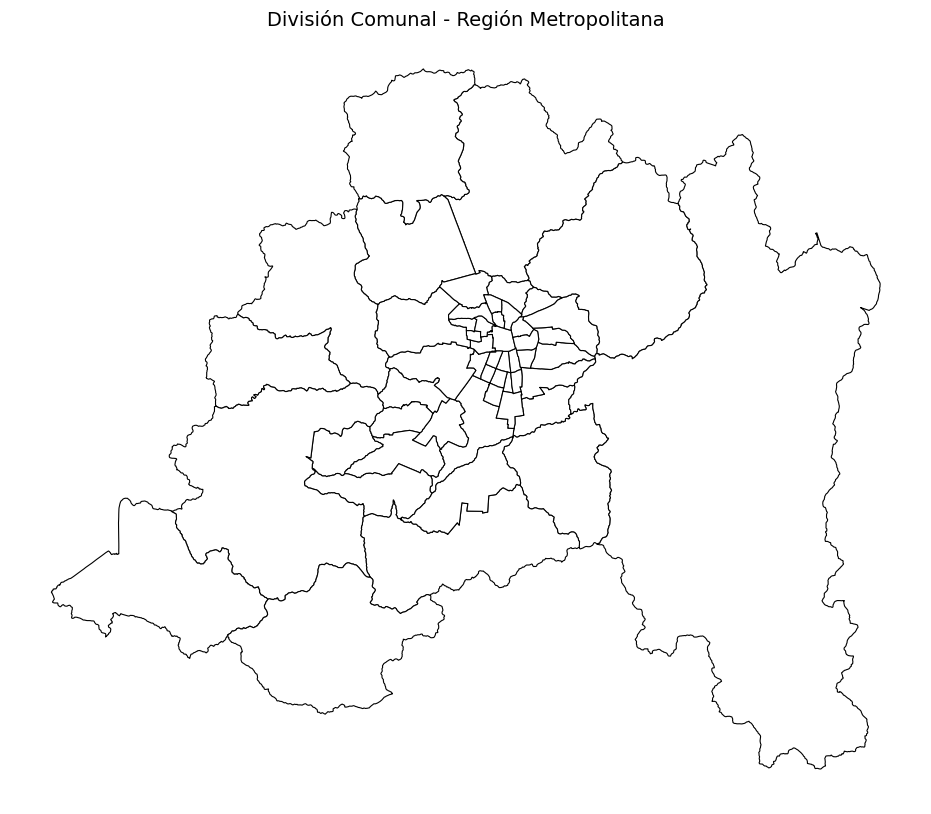

Visualización generada con 52 comunas.


In [7]:
# Visualización Base de la Región Metropolitana
ruta_busqueda = os.path.join("Datos", "Comunas", "**", "*.shp")
archivos_shp = glob.glob(ruta_busqueda, recursive=True)

if archivos_shp:
    ruta_mapa = archivos_shp[0]
    print(f"Cargando geometría desde: {ruta_mapa}")
    
    gdf_base = gpd.read_file(ruta_mapa)
    gdf_base.columns = [col.lower() for col in gdf_base.columns]
    
    # Detectar dinámicamente la columna de código de comuna en el shapefile
    posibles_cols_id = ['cod_comuna', 'cut_comuna', 'comuna_id', 'codigo']
    
    global col_id_shp # para usarlo en celdas posteriores si es necesario
    col_id_shp = next((c for c in posibles_cols_id if c in gdf_base.columns), None)
    
    if col_id_shp:
        # Forzar tipo entero en el mapa (ESTO ES CRÍTICO para coincidir con el DataFrame)
        gdf_base[col_id_shp] = pd.to_numeric(gdf_base[col_id_shp], errors='coerce').fillna(0).astype(int)
        
        # Filtrado 
        # Se utiliza la columna de codigos corregida
        codigos_rm = df_comunas['Codigo Comuna'].unique()
        gdf_mapa_rm = gdf_base[gdf_base[col_id_shp].isin(codigos_rm)].copy()
        
        # Verificación y Ploteo
        if not gdf_mapa_rm.empty:
             fig, ax = plt.subplots(figsize=(12, 10))
             gdf_mapa_rm.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)
             
             ax.set_title("División Comunal - Región Metropolitana", fontsize=14)
             ax.set_axis_off() 
             plt.show()
             
             print(f"Visualización generada con {len(gdf_mapa_rm)} comunas.")
        else:
            print("Error: No hay coincidencia de códigos entre el mapa y el DataFrame.")
            print(f"Muestra códigos mapa ({col_id_shp}): {gdf_base[col_id_shp].dropna().unique()[:5]}")
            print(f"Muestra códigos de tus datos: {codigos_rm[:5]}")
    else:
        print("Error: No se detectó una columna de código de comuna en el shapefile.")
        print(f"Columnas disponibles en el mapa: {list(gdf_base.columns)}")
else:
    print("Error Crítico: No se encontró ningún archivo .shp en la ruta Datos/Comunas.")

In [8]:

df_comunas["cod_comuna"] = df_comunas["Codigo Comuna"].astype(int)


In [9]:
#df_comunas.groupby(["Codigo Comuna", "Año", "std_math"]).size().head(20)
df_comunas.columns

Index(['Año', 'Codigo Comuna', 'Avg Reading Score', 'Avg Math Score', 'Comuna',
       'std_reading', 'std_math', 'cod_comuna'],
      dtype='object')

## **Cómo usar la visualización**

1. Selecciona **Lenguaje** o **Matemática**.  
2. Elige un año o usa la opción "Promedio Histórico".  
3. Haz clic en una comuna del mapa.  
4. Observa su evolución en el gráfico inferior.

In [10]:
# SISTEMA COMPLETO SIMCE RM


gdf_base_web = gdf_mapa_rm.to_crs(epsg=4326).copy() # proyecccion web
gdf_base_web[col_id_shp] = gdf_base_web[col_id_shp].fillna(0).astype(int) 

# --- Estado global del sistema ---
if "current_state" not in globals():
    current_state = {}


# --- SELECTORES ---
available_years = sorted(df_comunas['Año'].unique())
year_options = ['Promedio Histórico'] + available_years

df_labels = (
    df_comunas[['Codigo Comuna', 'Comuna']]
    .drop_duplicates()
    .sort_values('Comuna')
)
df_labels["label"] = df_labels["Codigo Comuna"].astype(str) + " - " + df_labels["Comuna"]



# Mantener estado global (asegúrate de usar 'year' consistentemente)
current_state.setdefault('score_type', 'Lenguaje')
current_state.setdefault('year', 'Promedio Histórico')
#current_state.setdefault('comuna_id', dropdown_comuna.value)


# --- 3. get_map_data ---
def get_map_data(year, score_type):
    if year == 'Promedio Histórico':
        df_year = (
            df_comunas.groupby('Codigo Comuna')
            .agg({
                'Avg Reading Score': 'mean',
                'Avg Math Score': 'mean',
                'Comuna': 'first'
            })
            .reset_index()
        )
        title_suffix = "(Promedio 2014–2024)"
    else:
        df_year = df_comunas[df_comunas['Año'] == year].copy()
        title_suffix = f"({year})"

    if score_type == "Lenguaje":
        col_target = "Avg Reading Score"
        title_base = "Simce Lenguaje"
        cmap = "yelloworangered"
    else:
        col_target = "Avg Math Score"
        title_base = "Simce Matemática"
        cmap = "yellowgreenblue"

    gdf_merged = gdf_base_web.merge(
        df_year,
        left_on='cod_comuna',
        right_on='Codigo Comuna',
        how='left'
    )

    gdf_merged["title"] = f"{title_base} {title_suffix}"
    gdf_merged["col_target"] = col_target

    return gdf_merged, col_target, f"{title_base} {title_suffix}", cmap


# --- 4. MAPA INTERACTIVO ---
output_map = widgets.Output()

#(Altair 5) para el selector sobre mapa
# ----------------------------------------------------



# ============================================
#     FUNCIÓN ACTUALIZADA: MAPA INTERACTIVO
# ============================================


# Asegurarse columna uniforme para unir
df_comunas['cod_comuna'] = df_comunas['Codigo Comuna'].astype(int)
gdf_base_web['cod_comuna'] = gdf_base_web['cod_comuna'].astype(int)

output_map.clear_output()

# ---- DEFINIR EL PARAM select_comuna ----
select_comuna = alt.selection_point(
    fields=["cod_comuna"],
    empty=False,   # <- CLAVE: no hay selección por defecto
    on="click",
    clear=False
)

# ---- RENDER MAP + LINE CHART
def render_combined():
    """
    Renderiza mapa + gráfico temporal en la misma especificación Altair.
    La selección en el mapa (select_comuna) filtra el gráfico temporal.
    """
    year = current_state["year"]
    score = current_state["score_type"]

    # 1) preparar datos por año (igual que get_map_data)
    if year == 'Promedio Histórico':
        df_year = (
            df_comunas.groupby('cod_comuna')
            .agg({
                'Avg Reading Score': 'mean',
                'Avg Math Score': 'mean',
                'Comuna': 'first'
            })
            .reset_index()
        )
    else:
        df_year = df_comunas[df_comunas['Año'] == year].copy()

    # 2) configurar columnas dependiendo de Lenguaje/Matemática
    if score == "Lenguaje":
        col_target = "Avg Reading Score"
        cmap = "yelloworangered"
        line_color = "#d97706"
    else:
        col_target = "Avg Math Score"
        cmap = "yellowgreenblue"
        line_color = "#2563eb"

    title_text = f"SIMCE {score} ({'Promedio 2014–2024' if year=='Promedio Histórico' else year})"

    # 3) merge para tener geometrías con valores
    gdf_plot = gdf_base_web.merge(
        df_year,
        left_on='cod_comuna',
        right_on='cod_comuna',
        how='left'
    )


    # 5) mapa (usa params=[select_comuna])
    map_chart = (
    alt.Chart(gdf_plot).add_params(select_comuna)
        .mark_geoshape(stroke='gray', strokeWidth=0.5)
        .encode(
            color=alt.Color(f"{col_target}:Q", title="Puntaje", scale=alt.Scale(scheme=cmap)),
            tooltip=[
                alt.Tooltip("Comuna:N", title="Comuna"),
                alt.Tooltip(f"{col_target}:Q", title="Puntaje", format=".1f"),
                alt.Tooltip("cod_comuna:Q", title="Código Comuna")
            ],
            opacity=alt.condition(select_comuna, alt.value(1), alt.value(0.6))
        )
        .properties(width=700, height=500, title=title_text)
        .project(type='identity', reflectY=True)
    )

    #std
    if score == "Lenguaje":
        std_col = "std_reading"
    else:
        std_col = "std_math"

    df_line = df_comunas.copy()
    df_line["lower"] = df_line[col_target] - df_line[std_col]
    df_line["upper"] = df_line[col_target] + df_line[std_col]



    # 6) gráfico temporal -> FILTRAR por la selección del mapa
    band_std = (
        alt.Chart(df_line)
        .mark_area(opacity=0.2)
        .encode(
            x="Año:O",
            y="lower:Q",
            y2="upper:Q"
        )
        .transform_filter(select_comuna)
    )

    
    #gráfico linea_chart
    line_chart = (
        alt.Chart(df_line)
        .mark_line(point=True, strokeWidth=2, color=line_color)
        .encode(
            x="Año:O",
            y=alt.Y(f"{col_target}:Q", scale=alt.Scale(zero=False)),
            tooltip=["Año", col_target, "Comuna", std_col]
        )
        .transform_filter(select_comuna)
        .properties(
            width=900,        # ← ancho firme
            height=350,
            title=f"Evolución SIMCE — {score}"
        )

    )



    # 7) banda gris (pandemia) como capa sobre el line_chart
    band = (
        alt.Chart(pd.DataFrame({"start":[2019],"end":[2021]}))
        .mark_rect(opacity=0.15, color="lightgray")
        .encode(x="start:O", x2="end:O")
    )
    line_with_band = band + band_std + line_chart

    message = alt.Chart(pd.DataFrame({"msg": ["Selecciona una comuna en el mapa"]}))
    message = message.mark_text(size=16, color="gray").encode(text="msg:N")


    # 8) unir verticalmente mapa y linea
    combined = alt.vconcat(map_chart, line_with_band).resolve_legend(color="independent")

    # 9) Display (usamos output_map para que la UI no salte)
    with output_map:
        clear_output(wait=True)
        display(combined)

render_combined()



# --- 6. EVENTOS y WIDGETS (conexiones) ---
def on_click_lenguaje(b):
    current_state["score_type"] = "Lenguaje"
    render_combined()

def on_click_matematica(b):
    current_state["score_type"] = "Matematica"
    render_combined()

def on_year_change(change):
    if change["name"] == "value":
        current_state["year"] = change["new"]
        render_combined()

def on_comuna_change(change):
    if change["name"] == "value":
        current_state["comuna_id"] = change["new"]
        render_combined()


btn_lenguaje = widgets.Button(description="Lenguaje", icon="book", button_style="warning", layout=widgets.Layout(width="150px"))
btn_matematica = widgets.Button(description="Matemática", icon="calculator", button_style="info", layout=widgets.Layout(width="150px"))

dropdown_year = widgets.Dropdown(options=year_options, value="Promedio Histórico", description="Año:", layout=widgets.Layout(width="200px"))

btn_lenguaje.on_click(on_click_lenguaje)
btn_matematica.on_click(on_click_matematica)
dropdown_year.observe(on_year_change)

# --- 7. DISPLAY ---
controls = widgets.HBox([btn_lenguaje, btn_matematica, widgets.Label(" | "), dropdown_year], layout=widgets.Layout(justify_content="center", margin="0 0 15px 0"))

display(controls)
display(output_map)

# Render inicial combinado
render_combined()




Output()